# Practical: MD and MC

In this practical, we will learn how to run MD simulations using ASE. We will also learn how to write a Monte Carlo code running a Ising model simulation.

## Molecular Dynamics: Cu Bulk
In this example, we will learn how to use molecular dynamics to simulate the melting of a copper crystal. We will use the EMT potential to describe the interactions between the atoms.

It's better to install the ASAP3 package to run the EMT potential, which is faster than the implementation in ASE. You can run the code below to install this package.

In [ ]:
!pip install asap3

The code has following steps:
1. Create a copper crystal.
2. Define the EMT potential.
3. Run the molecular dynamics simulation using `NVTBerendsen` algorithm. (NVT ensemble)
4. `MDLogger` to log the temperature and energy of the system.
5. Save the trajectory of the simulation.

In [2]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution,Stationary
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.verlet import VelocityVerlet
from ase.md.npt import NPT
from ase.md import MDLogger
from ase import units
import os
from time import perf_counter


def run_md(atoms, calculator, ensemble, time_step, temperature, num_md_steps, num_interval, output_filename):
    # Set calculator (EMT in this case)
    atoms.calc = calculator

    # Set the momenta corresponding to the given "temperature"
    MaxwellBoltzmannDistribution(atoms, temperature_K=temperature,force_temp=True)
    Stationary(atoms)  # Set zero total momentum to avoid drifting

    # Set output filenames
    log_filename = output_filename + ".log"
    print("log_filename = ",log_filename)
    traj_filename = output_filename + ".traj"
    print("traj_filename = ",traj_filename)

    # Remove old files if they exist
    if os.path.exists(log_filename): os.remove(log_filename)
    if os.path.exists(traj_filename): os.remove(traj_filename)

    # Define the MD dynamics class object
    if ensemble == 'nve':
        dyn = VelocityVerlet(atoms,
                             time_step * units.fs,
                             trajectory = traj_filename,
                             loginterval=num_interval
                            )
    elif ensemble == 'nvt':
        dyn = NVTBerendsen(atoms,
                           time_step * units.fs,
                           temperature_K=temperature,
                           taut=100.0 * units.fs,
                           trajectory = traj_filename,
                           loginterval=num_interval
                          )
    elif ensemble == 'npt':
        sigma   = 1.0     # External pressure in bar
        ttime   = 20.0    # Time constant in fs
        pfactor = 2e6     # Barostat parameter in GPa
        dyn = NPT(atoms,
          time_step*units.fs,
          temperature_K = temperature,
          externalstress = sigma*units.bar,
          ttime = ttime*units.fs,
          pfactor = pfactor*units.GPa*(units.fs**2),
          logfile = log_filename,
          trajectory = traj_filename,
          loginterval=num_interval
          )
    else:
        raise ValueError("Invalid ensemble, must be nve, nvt, or npt")
    
    # Print statements
    def print_dyn():
        imd = dyn.get_number_of_steps()
        etot  = atoms.get_total_energy()
        temp_K = atoms.get_temperature()
        stress = atoms.get_stress(include_ideal_gas=True)/units.GPa
        stress_ave = (stress[0]+stress[1]+stress[2])/3.0
        elapsed_time = perf_counter() - start_time
        print(f"  {imd: >3}   {etot:.3f}    {temp_K:.2f}    {stress_ave:.2f}  {stress[0]:.2f}  {stress[1]:.2f}  {stress[2]:.2f}  {stress[3]:.2f}  {stress[4]:.2f}  {stress[5]:.2f}    {elapsed_time:.3f}")


    dyn.attach(print_dyn, interval=num_interval)

    # Set MD logger
    dyn.attach(MDLogger(dyn, atoms, log_filename, header=True, stress=True,peratom=True, mode="w"), interval=num_interval)

    # Now run MD simulation
    print(f"    imd     Etot(eV)    T(K)    stress(mean,xx,yy,zz,yz,xz,xy)(GPa)  elapsed_time(sec)")
    start_time = perf_counter()
    dyn.run(num_md_steps)



In [ ]:
from asap3 import EMT
from ase.build import bulk

calculator = EMT()
# Set up a fcc-Cu crystal
atoms = bulk("Cu", "fcc", cubic=True, a=3.615)
atoms.pbc = True
atoms *= 3 # 3x3x3 supercell
print("atoms = ",atoms)

# input parameters
time_step    = 1.0      # MD step size in fsec
temperature  = 2000     # Temperature in Kelvin
num_md_steps = 100000   # Total number of MD steps
num_interval = 1000     # Print out interval for .log and .traj

output_filename = "./Cu_fcc_3x3x3"

ensemble = 'nvt'

run_md(atoms, calculator, ensemble, time_step, temperature, num_md_steps, num_interval, output_filename)


You can load the log file using pandas and see the evolution of the temperature and energy of the system.

In [4]:
import pandas as pd

log_filename = output_filename + ".log"
df = pd.read_csv(log_filename, delim_whitespace=True, skiprows=1,
                 names=['Time[ps]','Etot/N[eV]','Epot/N[eV]','Ekin/N[eV]','T[K]','stress(xx)','stress(yy)','stress(zz)','stress(yz)','stress(xz)','stress(xy)'])
df

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_81569/2482752699.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(log_filename, delim_whitespace=True, skiprows=1,


,Time[ps],Etot/N[eV],Epot/N[eV],Ekin/N[eV],T[K],stress(xx),stress(yy),stress(zz),stress(yz),stress(xz),stress(xy)
0,0.0,0.2586,0.0001,0.2585,2000.0,0.385,0.104,-0.316,0.077,-0.441,0.298
1,1.0,0.5082,0.2747,0.2334,1806.0,-12.154,-13.156,-12.876,-0.598,-0.266,-0.013
2,2.0,0.5114,0.2455,0.2659,2057.4,-12.480,-10.208,-11.662,-0.919,-1.241,0.543
3,3.0,0.5138,0.2513,0.2625,2031.0,-12.838,-10.754,-11.749,-0.935,-0.681,-0.617
4,4.0,0.5210,0.2825,0.2385,1845.1,-13.969,-12.831,-12.218,-0.051,-0.746,-0.383
...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,0.5160,0.2615,0.2545,1968.9,-12.081,-13.889,-10.374,0.270,-0.288,-2.513
97,97.0,0.5151,0.2621,0.2530,1957.1,-12.719,-11.206,-12.386,-0.261,0.593,-0.569
98,98.0,0.5191,0.2390,0.2800,2166.4,-12.415,-11.431,-10.552,0.693,-0.839,-0.285
99,99.0,0.5101,0.2492,0.2609,2018.3,-12.377,-11.767,-10.860,-0.825,-0.157,-1.389


You can plot the results using matplotlib.

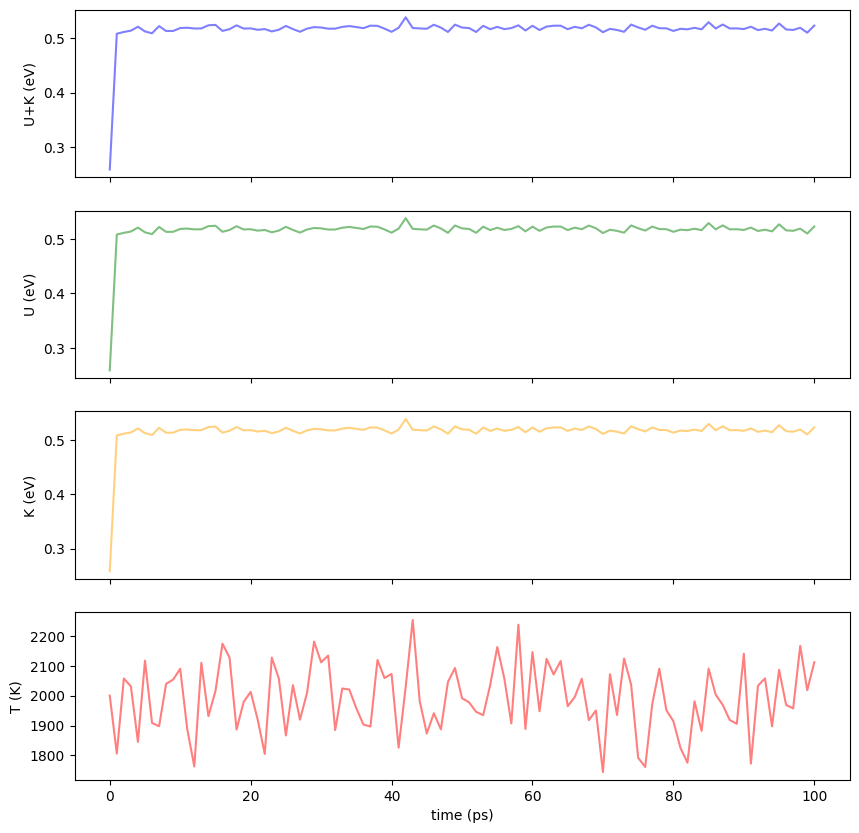

In [5]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 10))

#color = 'tab:grey'
ax1 = fig.add_subplot(4, 1, 1)
ax1.set_xticklabels([])
ax1.set_ylabel('U+K (eV)')
ax1.plot(df["Time[ps]"], df["Etot/N[eV]"], color="blue",alpha=0.5)

ax2 = fig.add_subplot(4, 1, 2)
ax2.set_xticklabels([])
ax2.set_ylabel('U (eV)')
ax2.plot(df["Time[ps]"], df["Etot/N[eV]"], color="green",alpha=0.5)

ax3 = fig.add_subplot(4, 1, 3)
ax3.set_xticklabels([])
ax3.set_ylabel('K (eV)')
ax3.plot(df["Time[ps]"], df["Etot/N[eV]"], color="orange",alpha=0.5)

ax4 = fig.add_subplot(4, 1, 4)
ax4.set_xlabel('time (ps)')
ax4.set_ylabel('T (K)')
ax4.plot(df["Time[ps]"], df["T[K]"], color="red",alpha=0.5)

plt.show()


### Visualizing the simulation
We can use ase-gui to visualize our results.

In [ ]:
!ase gui Cu_fcc_3x3x3.traj

## Molecular Dynamics: Thermal Expansion of Cu
In this example, we will learn how to use molecular dynamics to simulate the thermal expansion of a copper crystal. We will use the EMT potential to describe the interactions between the atoms.

Thermal expansion is the tendency of matter to change its shape, area, and volume in response to a change in temperature. The simulation will show how the copper crystal expands when heated. You can get thermal expansion coefficient from the fitting between the change in length and temperature:

$$
\Delta L = L_0 \alpha \Delta T
$$

where $\Delta L$ is the change in length, $L_0$ is the initial length, $\alpha$ is the coefficient of linear expansion, and $\Delta T$ is the change in temperature.

In [ ]:
from ase.build import bulk


# ASAP3-EMT calculator
calculator = EMT()

# Set up a crystal
atoms_in = bulk("Cu",cubic=True)
atoms_in *= 3
atoms_in.pbc = True
print("atoms_in = ",atoms_in)

calculator = EMT()
# Set up a fcc-Cu crystal
atoms = bulk("Cu", "fcc", cubic=True, a=3.615)
atoms.pbc = True
atoms *= 3 # 3x3x3 supercell
print("atoms = ",atoms)

# input parameters
time_step    = 1.0      # MD step size in fsec
num_md_steps = 20000   # Total number of MD steps
num_interval = 10     # Print out interval for .log and .traj
ensemble = 'npt'

temperature_list = [200,300,400,500,600,700,800,900,1000]

for temperature in temperature_list:
    output_filename = f"./Cu_fcc_3x3x3_NPT_T{temperature}"
    run_md(atoms, calculator, ensemble, time_step, temperature, num_md_steps, num_interval, output_filename)



In [8]:
!ase gui Cu_fcc_3x3x3_NPT_T1000.traj

2025-03-12 17:09:43.148 Python[81831:203242] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-12 17:09:43.148 Python[81831:203242] +[IMKInputSession subclass]: chose IMKInputSession_Modern


temperature =  [1000.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0]
path = Cu_fcc_3x3x3_NPT_T1000.traj
path = Cu_fcc_3x3x3_NPT_T200.traj
path = Cu_fcc_3x3x3_NPT_T300.traj
path = Cu_fcc_3x3x3_NPT_T400.traj
path = Cu_fcc_3x3x3_NPT_T500.traj
path = Cu_fcc_3x3x3_NPT_T600.traj
path = Cu_fcc_3x3x3_NPT_T700.traj
path = Cu_fcc_3x3x3_NPT_T800.traj
path = Cu_fcc_3x3x3_NPT_T900.traj
lat_a =  [11.016588472963502, 10.821537323116821, 10.843209475881546, 10.865002946470856, 10.888083692365838, 10.90907108237643, 10.934065596136895, 10.959476356821698, 10.988588995565816]
norm_lat_a =  [1.01802435 1.         1.00200269 1.00401658 1.00614944 1.00808885
 1.01039855 1.01274671 1.01543696]
Linear thermal expansion coefficient: 2.235160e-05 K^-1


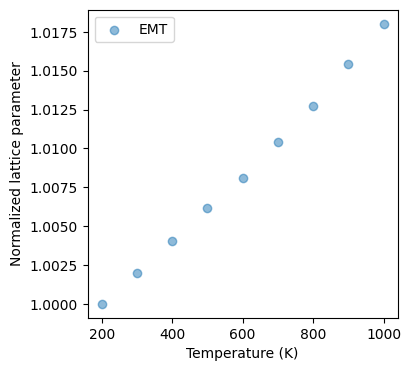

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read,Trajectory

time_step = 10.0  # Time step size between each snapshots recorded in traj
paths = [f"Cu_fcc_3x3x3_NPT_T{Temp}.traj" for Temp in temperature_list]
path_list = sorted([ p for p in paths ])

# Temperature list extracted from the filename
temperature = [float(p.split("_T")[1].split('.traj')[0]) for p in path_list]
print("temperature = ", temperature)

# Compute lattice parameter
lat_a = []
for path in path_list:
    print(f"path = {path}")
    traj = Trajectory(path)
    vol = [ atoms.get_volume() for atoms in traj ]
    lat_a.append(np.mean(vol[int(len(vol)/2):])**(1/3))

print("lat_a = ",lat_a)

# Normalize relative to the value at 300 K (which is at index 1 in the temperature_list)
norm_lat_a = np.array(lat_a)/lat_a[1]
print("norm_lat_a = ", norm_lat_a)
# Compute linear thermal expansion coefficient
# For linear thermal expansion coefficient α = (1/L)*(dL/dT)
# where L is the lattice parameter at reference temperature (300K)

# Using polyfit to get the slope of lattice parameter vs temperature
coef = np.polyfit(temperature, norm_lat_a, 1)
slope = coef[0]  # This is dL/dT normalized by L at 300K
alpha = slope  # Since we normalized by L at 300K, this is directly the coefficient

# Create a linear fit line for plotting
fit_line = np.polyval(coef, temperature)

# Print the thermal expansion coefficient
print(f"Linear thermal expansion coefficient: {alpha:.6e} K^-1")
# Plot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Temperature (K)')  # x axis label
ax.set_ylabel('Normalized lattice parameter')  # y axis label
ax.scatter(temperature[:len(norm_lat_a)],norm_lat_a, alpha=0.5,label='EMT')
ax.legend(loc="upper left")


## Monte Carlo: Ising Model

In this practical, we will use Monte Carlo simulations to study the Ising model. The Ising model is a simple model of a ferromagnet, where spins on a lattice interact with their nearest neighbors. The Hamiltonian of the Ising model is given by

$$
H = -J \sum_{\langle i, j \rangle} s_i s_j - h \sum_i s_i,
$$

where $s_i = \pm 1$ are the spins on the lattice sites, $J$ is the coupling constant, $h$ is the external magnetic field, and the sum $\langle i, j \rangle$ is over nearest neighbors. We will consider the case of a 2D square lattice with periodic boundary conditions. In this simulation, $J=1$, $\beta = 1/T$ and $h=0$. $k_B$ is set to 1.

### Accelerate Python Code with Numba
The Monte Carlo simulation can be quite slow if implemented in pure Python. To speed up the simulation, we will use the Numba library, which can be used to compile Python code to machine code. To use Numba, you need to install it using `pip install numba`. You can then use the `@njit` decorator to compile a function. For example:

There are few things to keep in mind when using Numba:
- Numba does not support all Python features. For example, it does not support classes or list comprehensions.
- Numba does not support all Python libraries. For example, you cannot directly use ASE or pymatgen inside your functions.
- Numba does not support all Python types. For example, it does not support complex numbers.

You should always test your Numba code to make sure it is working correctly.

In [10]:
!pip install numba


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

@njit
def initial_state(N):
    """
    Generate an N x N lattice with spins ±1.
    For better compatibility with Numba, using explicit array creation
    instead of relying on random.randint with subtraction.
    """
    config = np.empty((N, N), dtype=np.int64)
    for i in range(N):
        for j in range(N):
            # Randomly assign -1 or 1
            config[i, j] = 1 if np.random.random() < 0.5 else -1
    return config

@njit
def mc_step(config, beta, J):
    """
    Perform one Monte Carlo sweep using the Metropolis algorithm.
    One sweep means N*N spin update attempts.
    
    Parameters:
      config: 2D numpy array of spins
      beta: 1/T (temperature inverse in natural units, with J=kB=1)
      neighbor_list: Dictionary of neighbors for each site (ignored in this implementation)
    Returns:
      Updated spin configuration.
    """
    N = config.shape[0]
    for _ in range(N*N):
        # Generate random coordinates for spin flip attempt
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)
        s = config[i, j]
        
        # Calculate energy difference directly from neighbors
        nb_sum = 0
        nb_sum += config[(i+1) % N, j]
        nb_sum += config[(i-1) % N, j]
        nb_sum += config[i, (j+1) % N]
        nb_sum += config[i, (j-1) % N]
        
        # Energy change if we flip this spin
        dE = 2 * s * J * nb_sum
        
        # Metropolis acceptance criterion
        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            config[i, j] = -s
    
    return config

@njit
def calc_energy(config, J):
    """
    Calculate the total energy of the configuration.
    
    Hamiltonian: H = -J Σ_{<ij>} s_i s_j with J=1.
    Each neighbor pair is counted twice so we divide by 2.
    """
    N = config.shape[0]
    energy = 0
    for i in range(N):
        for j in range(N):
            S = config[i, j]
            # Calculate contribution from neighbors directly
            nb_sum = config[(i+1) % N, j] + config[(i-1) % N, j] + config[i, (j+1) % N] + config[i, (j-1) % N]
            energy += -S * J * nb_sum
    return energy / 2.0

@njit
def calc_magnetization(config):
    """
    Calculate the magnetization of the configuration.
    
    Magnetization: M = Σ s_i
    """
    return np.sum(config)

@njit
def run_simulation(N, T, n_equil, n_steps, J):
    """
    Run a simulation at a specific temperature and return results
    """
    beta = 1.0 / T
    config = initial_state(N)
    
    # Equilibration
    for _ in range(n_equil):
        config = mc_step(config, beta, J)
    
    # Measurement
    E_total = 0.0
    M_total = 0.0
    configs = np.zeros((n_steps//100 + 1, N, N), dtype=np.int64)
    configs[0] = config.copy()
    
    save_idx = 1
    for step in range(n_steps):
        config = mc_step(config, beta, J)
        E_total += calc_energy(config, J)
        M_total += abs(calc_magnetization(config))
        
        if step % 100 == 0 and save_idx < len(configs):
            configs[save_idx] = config.copy()
            save_idx += 1
            
    E_avg = E_total / (n_steps * N * N)
    M_avg = M_total / (n_steps * N * N)
    
    return E_avg, M_avg, configs

# Function to create animation
def create_ising_animation(N=64, T=2.27, n_equil=1000, n_steps=10000, J=1):
    import plotly.graph_objects as go
    
    _, _, configs = run_simulation(N, T, n_equil, n_steps, J)
    
    # Create initial figure
    fig = go.Figure(
        data=go.Heatmap(
            z=configs[0],
            colorscale='RdBu',  # Red-Blue colorscale similar to coolwarm
            showscale=True,
            colorbar=dict(title='Spin'),
            zmin=-1, zmax=1
        ),
        layout=go.Layout(
            title=f'Ising Model at T = {T:.2f}, Frame 0',
            width=700, height=700,
            updatemenus=[{
                'type': 'buttons',
                'buttons': [{
                    'label': 'Play',
                    'method': 'animate',
                    'args': [None, {'frame': {'duration': 100, 'redraw': True}, 'fromcurrent': True}]
                }, {
                    'label': 'Pause',
                    'method': 'animate',
                    'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate'}]
                }],
                'direction': 'left',
                'pad': {'r': 10, 't': 10},
                'showactive': False,
                'x': 0.1,
                'y': 0,
                'xanchor': 'right',
                'yanchor': 'top'
            }],
            sliders=[{
                'active': 0,
                'yanchor': 'top',
                'xanchor': 'left',
                'currentvalue': {
                    'visible': True,
                    'prefix': 'Frame: ',
                    'xanchor': 'right'
                },
                'transition': {'duration': 100},
                'pad': {'b': 10, 't': 50},
                'len': 0.9,
                'x': 0.1,
                'y': 0,
                'steps': [{
                    'method': 'animate',
                    'label': str(i),
                    'args': [[str(i)], {
                        'frame': {'duration': 100, 'redraw': True},
                        'mode': 'immediate',
                        'transition': {'duration': 100}
                    }]
                } for i in range(len(configs))]
            }]
        ),
        frames=[go.Frame(
                data=[go.Heatmap(z=configs[i])],
                name=str(i),
                layout=go.Layout(title_text=f'Ising Model at T = {T:.2f}, Frame {i}')
            ) for i in range(len(configs))
        ]
    )
    
    return fig

# Function to run full simulation with temperature sweep
def run_ising_simulation(N=64, temps=None, n_equil=1000, n_steps=10000, J=1):
    if temps is None:
        temps = np.linspace(1.5, 3.5, 21)
    
    magnetizations = []
    energies = []
    specific_heats = []
    
    for T in temps:
        print(f"Simulating T = {T:.2f}")
        E_avg, M_avg, configs = run_simulation(N, T, n_equil, n_steps, J)
        energies.append(E_avg)
        magnetizations.append(M_avg)
        
        # Calculate energy fluctuations for specific heat
        # Need to run an additional loop to collect E^2 samples
        beta = 1.0 / T
        config = configs[-1].copy()  # Use the last config as starting point
        E_total = 0.0
        E_squared_total = 0.0
        
        for _ in range(n_steps):
            config = mc_step(config, beta, J)
            E = calc_energy(config, J)
            E_total += E
            E_squared_total += E**2
            
        E_avg = E_total / n_steps
        E_squared_avg = E_squared_total / n_steps
        # Specific heat: C = (β^2 / N^2) * (<E^2> - <E>^2)
        C = (beta**2) * (E_squared_avg - E_avg**2) / (N**2)

        specific_heats.append(C)
        
        print(f"T = {T:.2f}, E = {E_avg:.3f} eV/spin, |M| = {M_avg:.3f}, C = {C:.3f}")
        
    # Create plot with 3 panels
    fig_mag, ax_mag = plt.subplots(figsize=(6, 5))
    fig_eng, ax_eng = plt.subplots(figsize=(6, 5))
    fig_heat, ax_heat = plt.subplots(figsize=(6, 5))
    
    ax_mag.plot(temps, magnetizations, 'o-', label='|M| per spin')
    ax_mag.set_xlabel('Temperature T')
    ax_mag.set_ylabel('Average Magnetization per Spin')
    ax_mag.set_title('Magnetization vs Temperature')
    ax_mag.set_xlim(temps[0], temps[-1])
    ax_mag.legend()
    
    ax_eng.plot(temps, energies, 's-', color='red', label='E per spin')
    ax_eng.set_xlabel('Temperature T')
    ax_eng.set_ylabel('Average Energy per Spin')
    ax_eng.set_title('Energy vs Temperature')
    ax_eng.set_xlim(temps[0], temps[-1])
    ax_eng.legend()
    
    ax_heat.plot(temps, specific_heats, '^-', color='green', label='C per spin')
    ax_heat.set_xlabel('Temperature T')
    ax_heat.set_ylabel('Specific Heat per Spin')
    ax_heat.set_title('Specific Heat vs Temperature')
    ax_heat.set_xlim(temps[0], temps[-1])    
    
    
    fig_mag.tight_layout()
    fig_eng.tight_layout()
    fig_heat.tight_layout()
    fig_mag.show()
    fig_eng.show()
    fig_heat.show()
    

    return temps, magnetizations, energies, specific_heats



There is a critical point in the Ising model, where the system undergoes a phase transition from a ferromagnetic phase to a paramagnetic phase. At the critical point, the correlation length diverges, and the system exhibits critical behavior. Above the critical temperature, the system is in the paramagnetic phase, and the spins are disordered. Below the critical temperature, the system is in the ferromagnetic phase, and the spins are ordered.

In [ ]:
# Display animation for temperature near critical point
fig = create_ising_animation(N=32, T=2.3, n_equil=0, n_steps=5000, J=1)
fig.show()


Simulating T = 1.50
T = 1.50, E = -1998.281 eV/spin, |M| = 0.986, C = 0.202
Simulating T = 1.60
T = 1.60, E = -1974.060 eV/spin, |M| = 0.952, C = 0.263
Simulating T = 1.70
T = 1.70, E = -1945.115 eV/spin, |M| = 0.970, C = 0.330
Simulating T = 1.80
T = 1.80, E = -1903.277 eV/spin, |M| = 0.957, C = 0.437
Simulating T = 1.90
T = 1.90, E = -1852.117 eV/spin, |M| = 0.938, C = 0.580
Simulating T = 2.00
T = 2.00, E = -1789.262 eV/spin, |M| = 0.911, C = 0.733
Simulating T = 2.10
T = 2.10, E = -1702.887 eV/spin, |M| = 0.868, C = 0.917
Simulating T = 2.20
T = 2.20, E = -1585.172 eV/spin, |M| = 0.807, C = 1.248
Simulating T = 2.30
T = 2.30, E = -1382.420 eV/spin, |M| = 0.575, C = 2.077
Simulating T = 2.40
T = 2.40, E = -1238.892 eV/spin, |M| = 0.266, C = 1.141
Simulating T = 2.50
T = 2.50, E = -1134.661 eV/spin, |M| = 0.209, C = 0.822
Simulating T = 2.60
T = 2.60, E = -1057.152 eV/spin, |M| = 0.158, C = 0.690
Simulating T = 2.70
T = 2.70, E = -989.623 eV/spin, |M| = 0.115, C = 0.639
Simulating T 

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_81569/4235096978.py:253: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_81569/4235096978.py:254: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/b4/hm0mlm2x6_g1cbpp4c29f62h0000gn/T/ipykernel_81569/4235096978.py:255: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



(array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7,
        2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 [0.9864607421875,
  0.95199609375,
  0.9700826171875,
  0.957310546875,
  0.938246875,
  0.9113080078125,
  0.8683888671875,
  0.806830078125,
  0.57540625,
  0.2664828125,
  0.209254296875,
  0.1582486328125,
  0.1150015625,
  0.1083556640625,
  0.090970703125,
  0.0858916015625,
  0.079312109375,
  0.0694099609375,
  0.068980078125,
  0.062595703125,
  0.0621296875],
 [-1.9509796875,
  -1.919051171875,
  -1.898425,
  -1.86013125,
  -1.809321875,
  -1.745787109375,
  -1.66183671875,
  -1.5584171875,
  -1.377164453125,
  -1.199950390625,
  -1.110231640625,
  -1.032401953125,
  -0.96030625,
  -0.910285546875,
  -0.86024296875,
  -0.818353125,
  -0.779191796875,
  -0.74635625,
  -0.71366796875,
  -0.685819140625,
  -0.65995390625],
 [0.20184206881963795,
  0.2630845824585393,
  0.329875791035869,
  0.43726392510622236,
  0.5796210245412704,
  0.7329023306249383,
  0

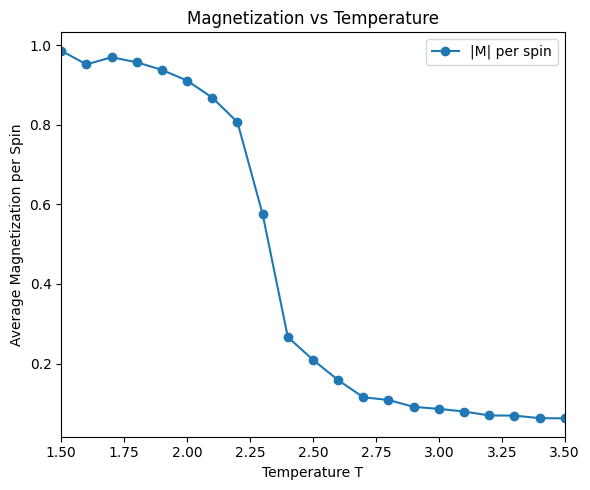

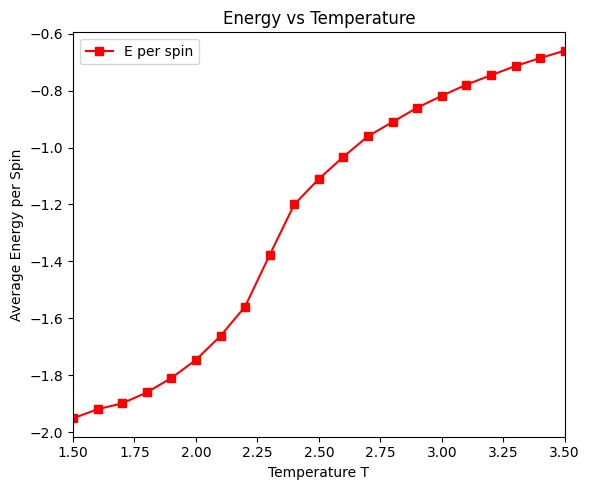

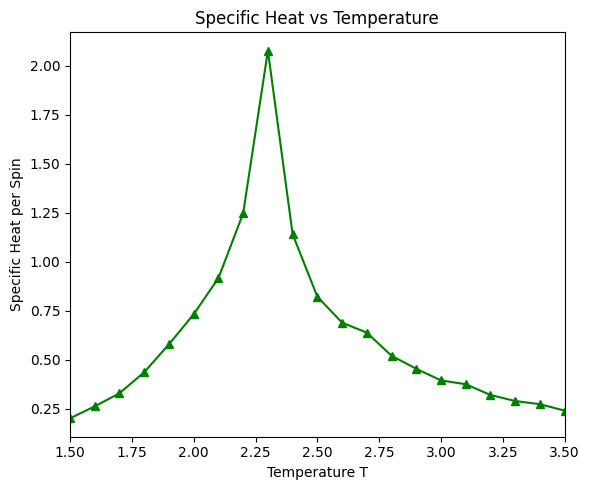

In [17]:
# For full simulation with temperature sweep
run_ising_simulation(N=32, n_equil=1000, n_steps=10000, J=1)

When J=-1, the system becomes anti-ferromagnetic. At low temperature, the system has a checkerboard pattern with alternating spins.

In [ ]:
fig = create_ising_animation(N=32, T=1, n_equil=0, n_steps=500, J=-1)
fig.show()